# Self-driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

In this project i will use the tools I learned about the lesson to identify curvature lane lines, to make transform perspective, to apply Sobel gradient, to change color image space and to calibrate camera. Firs, I will develop my pipeline on a series of individual images (included in "test_images" folder), and later apply the result to a video stream contained in this repository ("project_video.mp4"). The output video can be seen in "the output_images" folder. 

    Note: Run the cell below to import the packages. If you get an `import error` for a package you have already installed, try changing your kernel (This notebook was written in python 3). If you still have problems, try relaunching Jupyter  Notebook from the terminal prompt.Otherwise, feel free create a issue. Finally, you can write me via email.
    
## Import Packages

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import imageio
import os, sys


## Camera Calibration using chessboard images

In this step any distortion produced by the camera will be removed on the images. For it, the distortion coefficients and calibration matrix will be calculated by using 20 test chessboard images

In [3]:
# read the image to calibration camera
images = glob.glob('camera_cal/calibration*.jpg')

# declare the object points
obj = np.zeros((6*9, 3), np.float32)
obj[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# array to store object points and image points
objpoints = [] # 3D coordinates. Real world.
imgpoints = [] # 2D coordinate. Plane image.

# search fo chessboard corners
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    #If the corners were founded ret==True.
    if ret :
        #save the object and image points
        objpoints.append(obj)
        imgpoints.append(corners)


# perfom the camera calibration. Obtain matrix and sitortion coefficients.
val, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


* #### Testing Camera Calibration

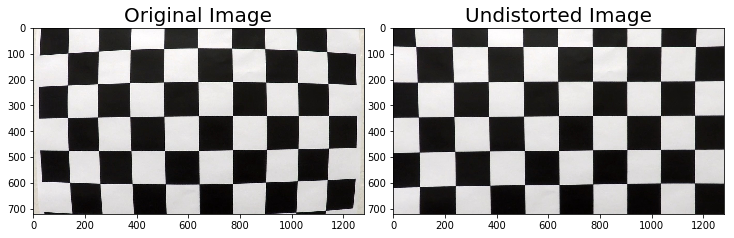

In [4]:
#read image example to corroborate the camera calibration
example = mpimg.imread('camera_cal/calibration1.jpg')
# undistort the image example
undist = cv2.undistort(example, mtx, dist, None, mtx)
#show the original and undistorted images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(example)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(undist)
ax[1].set_title('Undistorted Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('output_images/CalibrationExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Gradient and Color Thresholding
In this section, after having the camera calibrated, I will create binary thresholded images to warp the images, therefore, i will get a top-down view the lane lines. For that, I will use the S-Channel of HLS space, the L-Channel of LUV space and the B-Channel of LAB space.

In [5]:
def gradient_thresh(img, kernel=3, sobel_thresh =(20, 100), lab_thresh = (0,255), hls_thresh = (0,255), show = True):
    # copy images
    image1 = np.copy(img)
    # undistort the image example
    undist1 = cv2.undistort(image1, mtx, dist, None, mtx)
    #Change color space to HLS. Avoid the shadow errors
    hls1 = cv2.cvtColor(image1, cv2.COLOR_RGB2HLS)[:,:,2]
    # reduce noise
    cv2.GaussianBlur(hls1, (kernel,kernel), 0)
    #Change color space to LAB. Detect better the yellow lines
    lab1 = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)[:,:,2]
    #applied sobel gradient to lines closer to vertical
    sobelx1 = np.absolute(cv2.Sobel(hls1, cv2.CV_64F, 1, 0, ksize= kernel))
    #scale to 8-bit, 0-255 values
    scaled_sobel1 = np.uint8(255*sobelx1/np.max(sobelx1))
    # Threshold by gradient
    sobel_binary1 = np.zeros_like(scaled_sobel1)
    #aplly threshold sobel image
    sobel_binary1[(scaled_sobel1>=sobel_thresh[0]) & (scaled_sobel1<=sobel_thresh[1])] = 1
    #Threshold color b-channel 
    b_binaryLAB = np.zeros_like(lab1)
    b_binaryLAB[lab1>=lab_thresh[0]] = 1
    #Threshold color s-channel
    s_binaryHLS = np.zeros_like(hls1)
    s_binaryHLS[hls1>=hls_thresh[0]] = 1
    #combined threshold
    combined_binary = np.zeros_like(hls1)
    combined_binary[(sobel_binary1 == 1) | (b_binaryLAB == 1) | (s_binaryHLS == 1) ] = 1
    
    if show:
        fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey='col',sharex= 'row', figsize=(15,10))
        fig.tight_layout()

        ax1.set_title('Original Image', fontsize= 20)
        ax1.imshow(img)
        ax2.set_title('Sobel Gradient', fontsize= 20)
        ax2.imshow(sobel_binary1, cmap = 'gray')
        ax3.set_title('B-channel Image', fontsize= 20)
        ax3.imshow(b_binaryLAB, cmap = 'gray')
        ax4.set_title('S-channel Image', fontsize= 20)
        ax4.imshow(s_binaryHLS, cmap = 'gray')
        f.tight_layout(pad=0)
        fig.savefig('camera_cal/TransformExample2.jpg', transparent= False, bbox_inches='tight', pad_inches=0)
        plt.figure(figsize=(30,20))
        plt.title('Combined threshold', fontsize= 30)
        plt.imshow(combined_binary, cmap = 'gray')
    return combined_binary

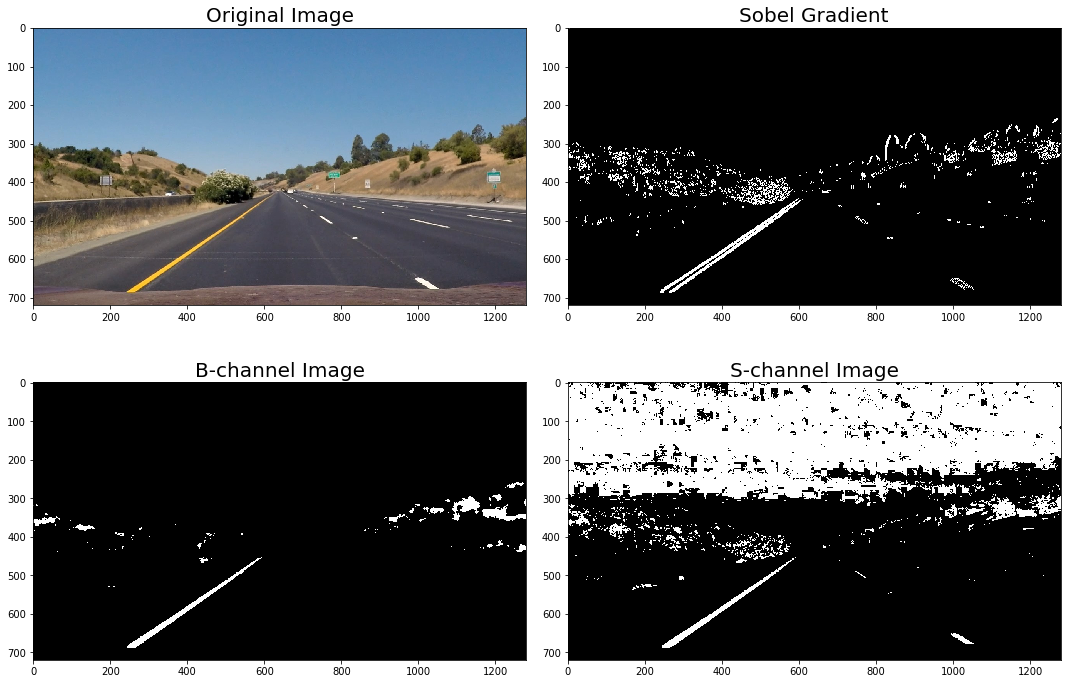

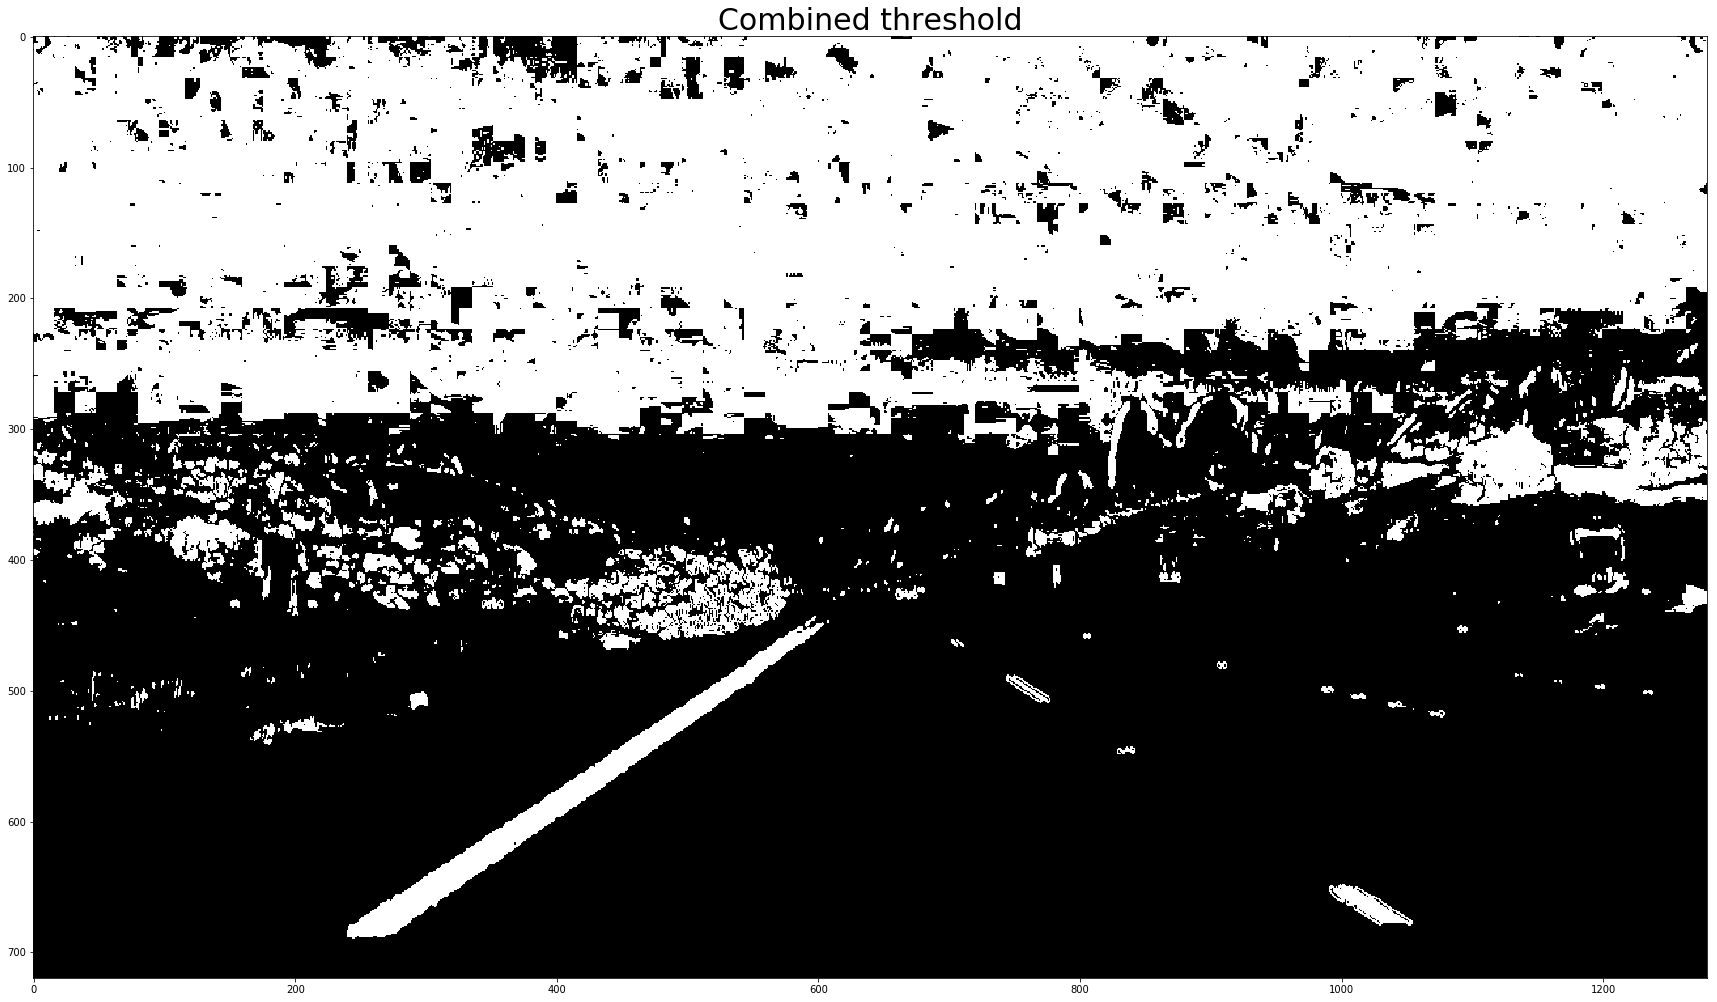

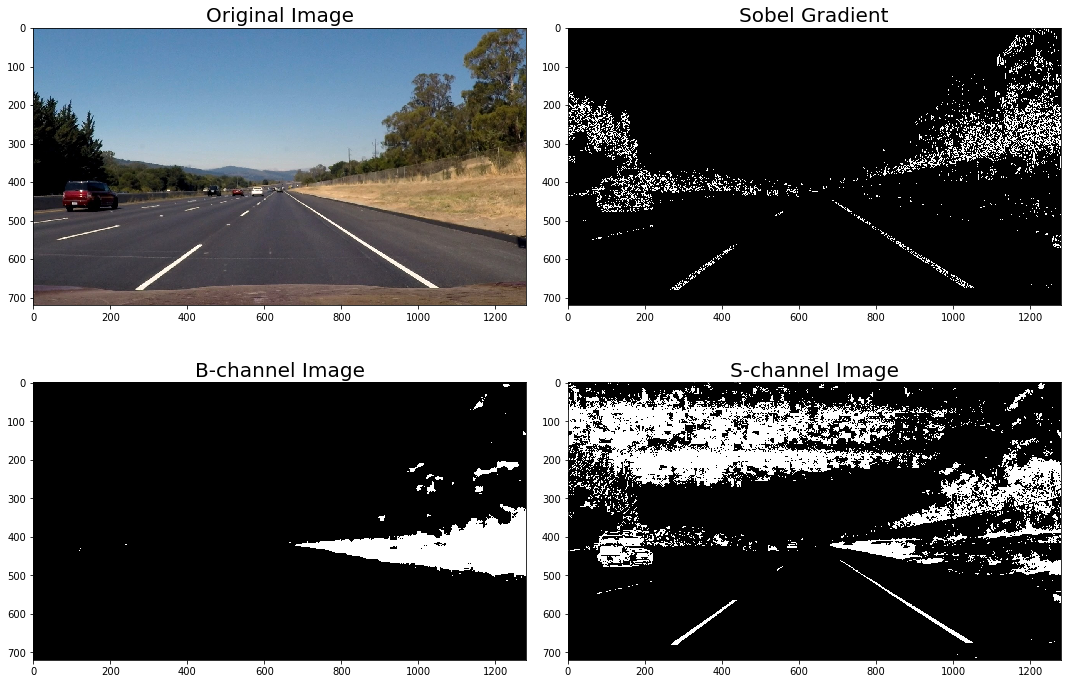

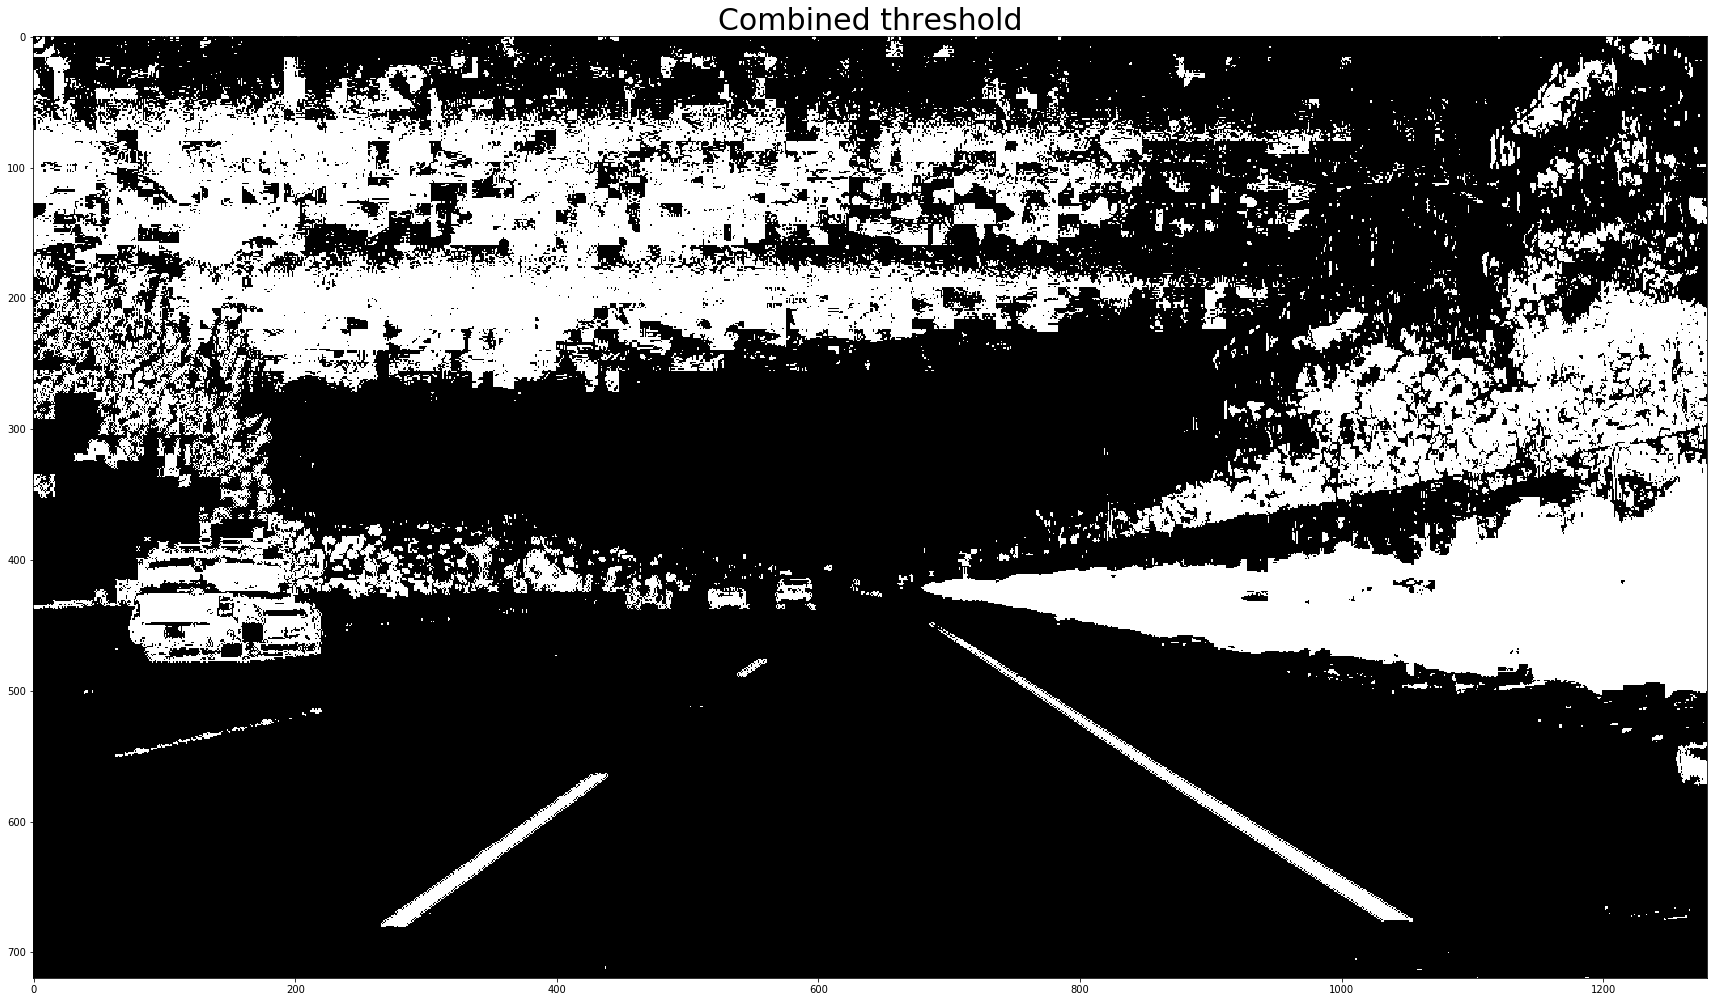

In [6]:
# import two images 
img1 = mpimg.imread('test_images/straight_lines1.jpg')
img2 = mpimg.imread('test_images/straight_lines2.jpg')

binary_img1 = gradient_thresh(img1, 7, (20, 100), (155, 255), (100, 255), show = True )
binary_img2 = gradient_thresh(img2, 3, (20, 100), (155, 255), (100, 255), show = True )

## Apply Mask
I will us this function to define the region of interest on the images.

In [7]:
# Apply mask 
def region_of_interest(img, vertices):
    """Applies an image mask
    
    Only keeps the region of the image defined by th epolygon formed
    from ´vertices´. The rest of the image is set to black. 
    ´vertices´ should be a numpe array of integer points"""
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape)>2 :
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255    
    #filling pixels inside the polygon defined by ¨vertices¨ with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

* #### Testing mask region of interest

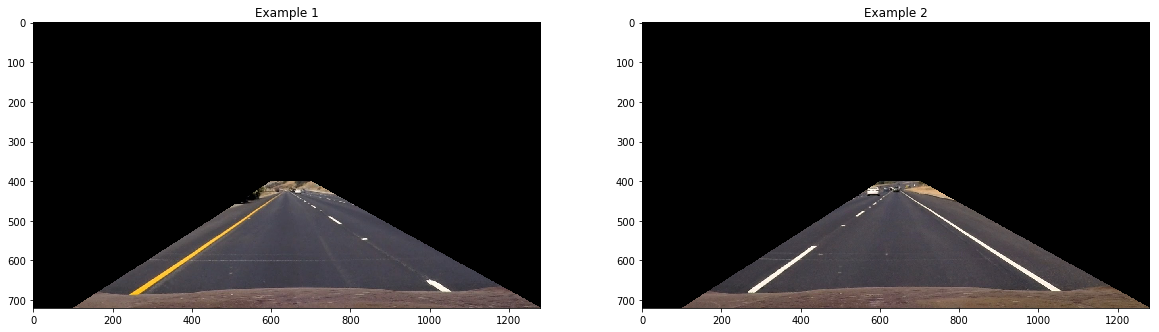

In [8]:
vertices = np.array([[(100, img1.shape[0]),(600,400), (700, 400), (img1.shape[1], img1.shape[0])]], dtype=np.int32)
masked1 = region_of_interest(img1, vertices)
masked2 = region_of_interest(img2, vertices)
plt.figure(figsize=(20,30))
plt.subplot(1, 2, 1)
plt.title('Example 1')
plt.imshow(masked1)
plt.subplot(1, 2, 2)
plt.title('Example 2')
plt.imshow(masked2)

* #### Applying mask to threshold binary  image.

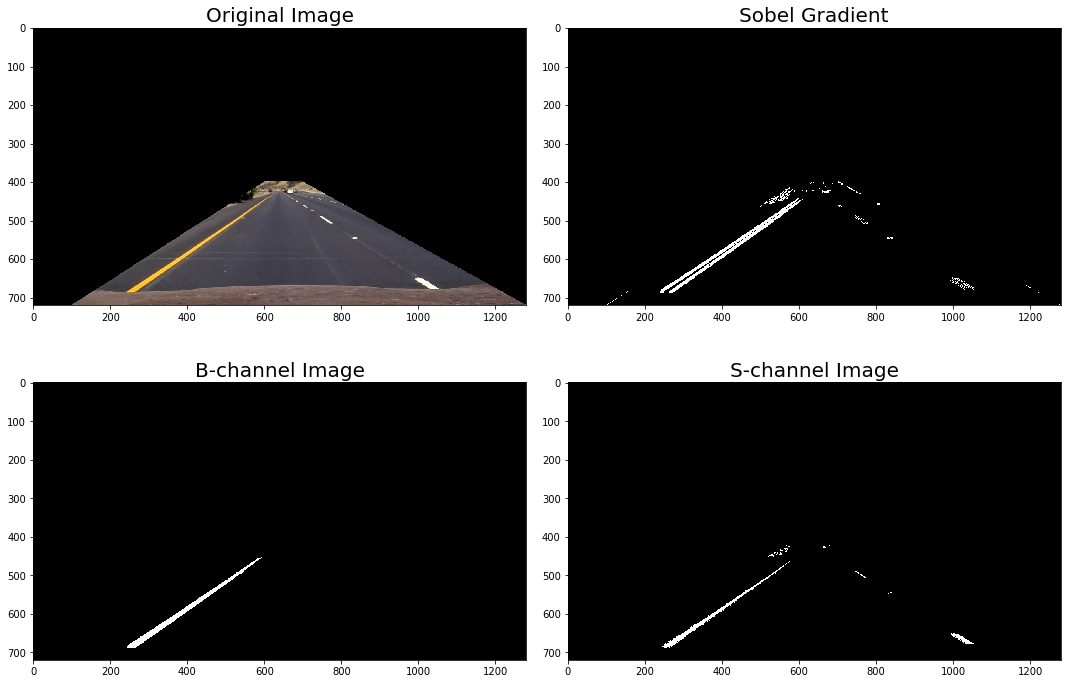

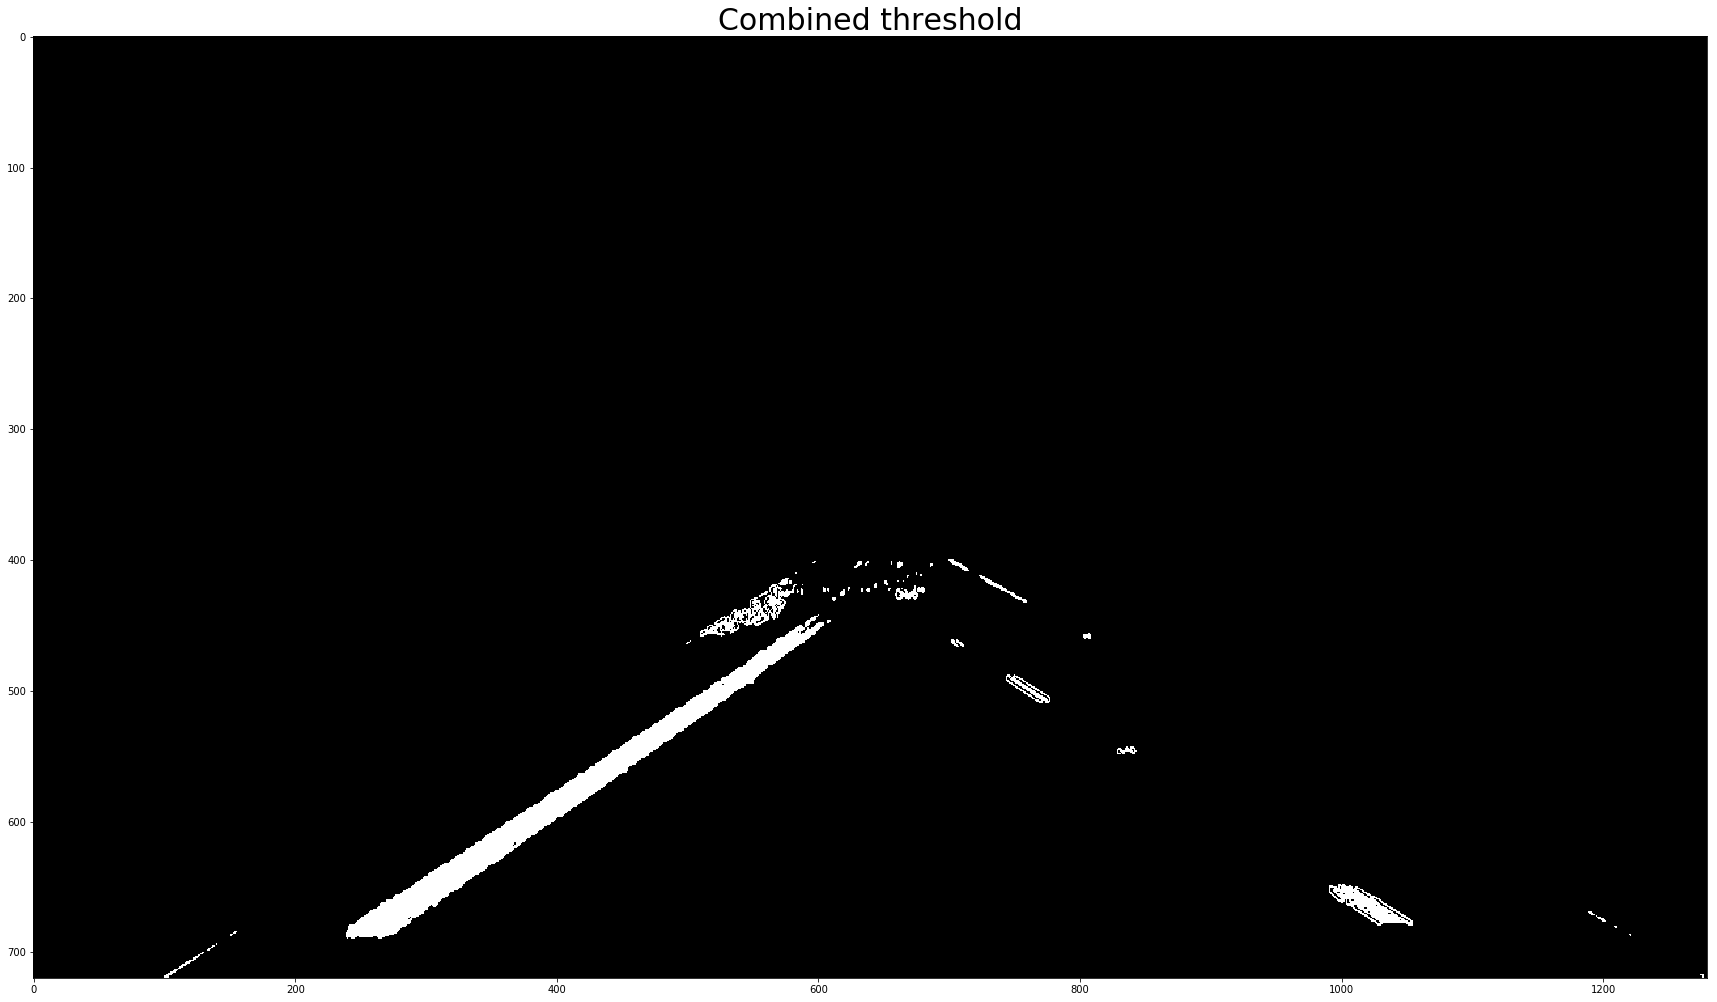

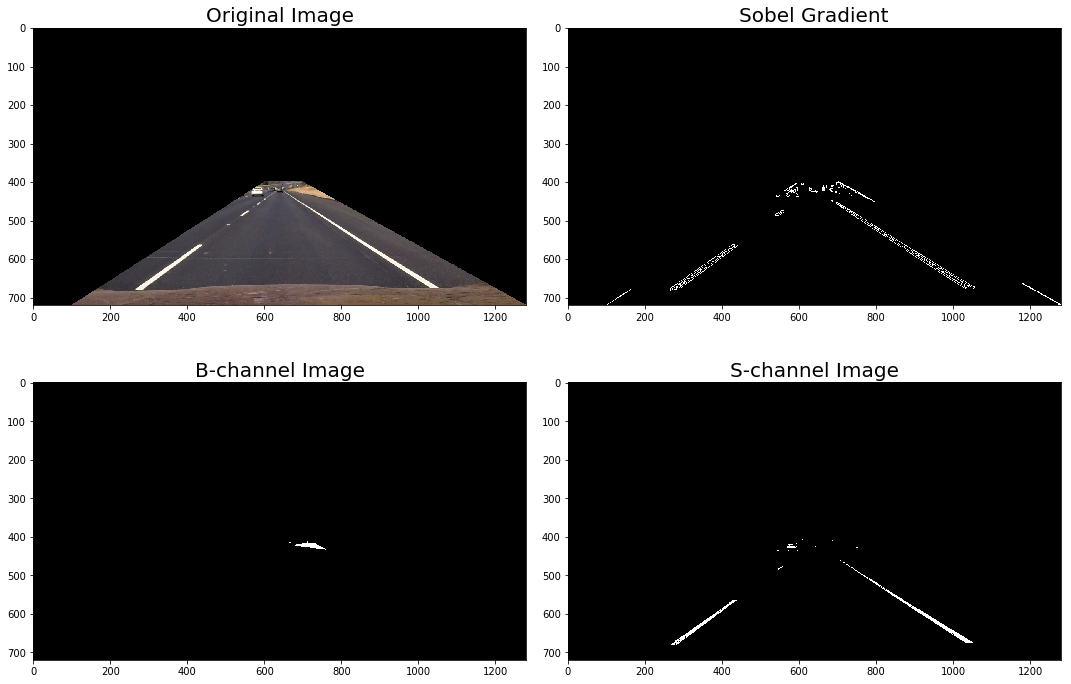

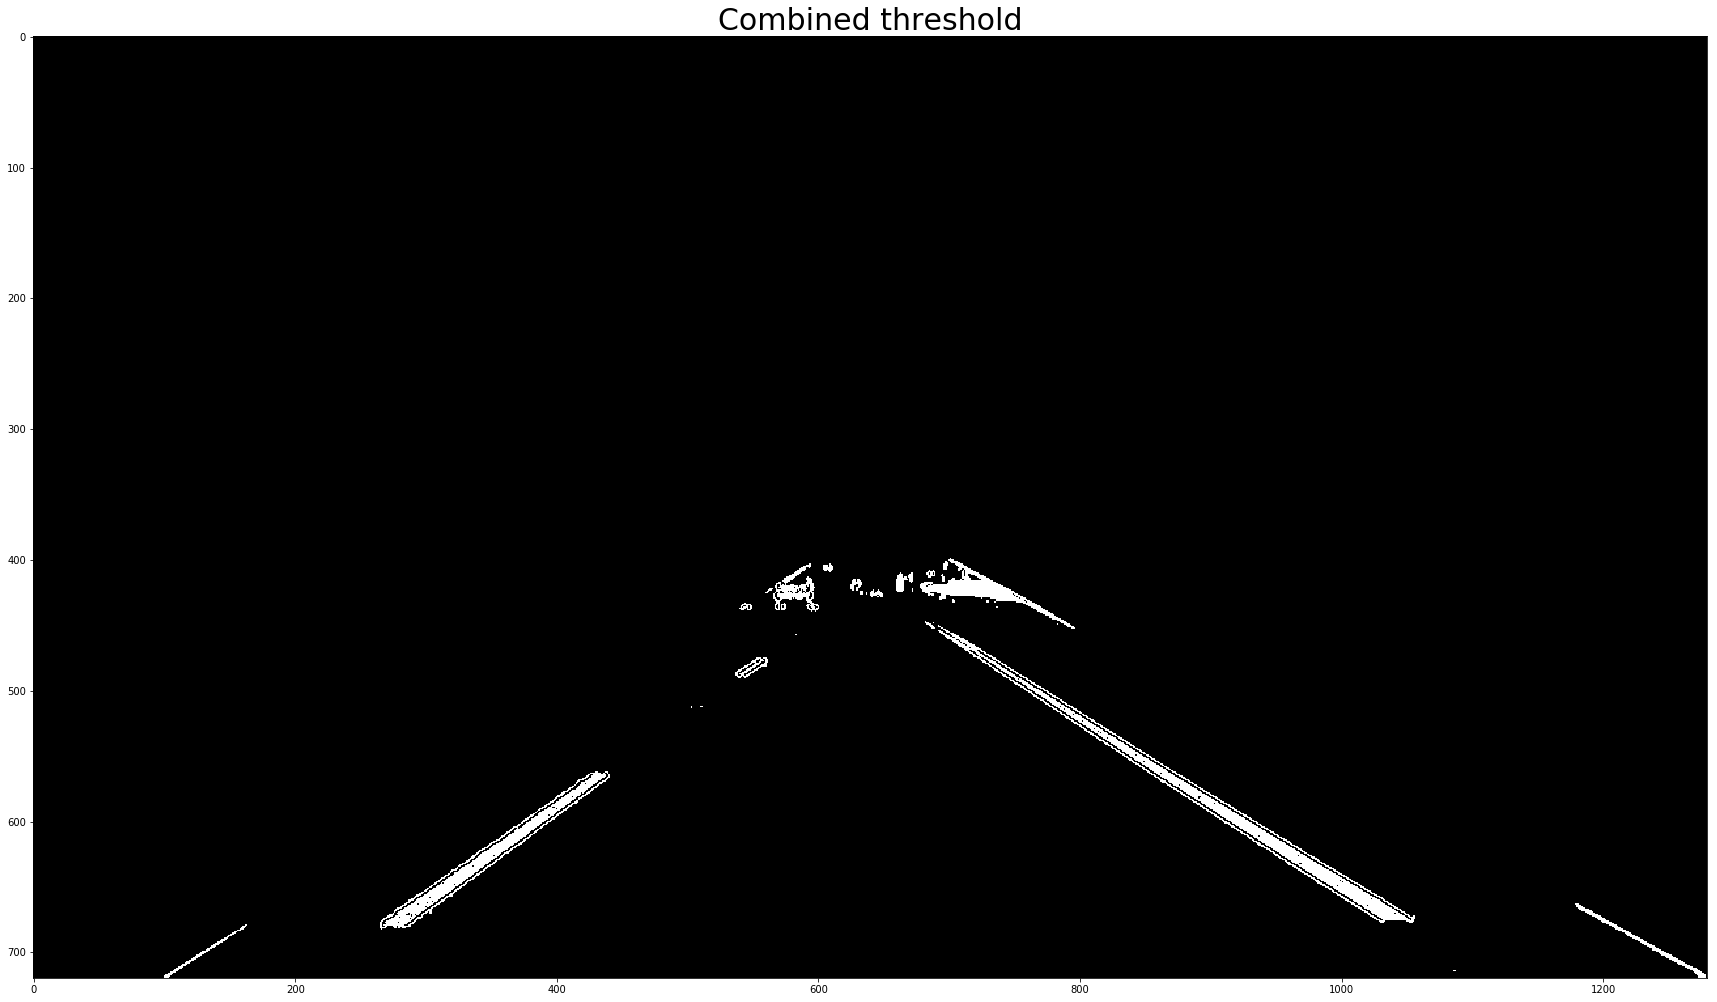

In [9]:
binary_img1 = gradient_thresh(masked1, 7, (20, 100), (155, 255), (160, 255), show = True )
binary_img2 = gradient_thresh(masked2, 7, (20, 100), (155, 255), (160, 255), show = True )

## Perspective Transformation

In [10]:
# define perspective transform function
def warped(img, src, dst):
    #img: unwarped image. src: source original coordinates. dst: destination coordinates. 
    #compute and apply perpective transform function
    img_size = (img.shape[1], img.shape[0])
    # Get matrix coefficients
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_NEAREST)
    return warped, M

* #### Testing Perspective Transformation

[[ 575.  460.]
 [ 188.  720.]
 [1120.  720.]
 [ 708.  460.]]
----
[[400.   1.]
 [400. 720.]
 [800. 720.]
 [800.   1.]]


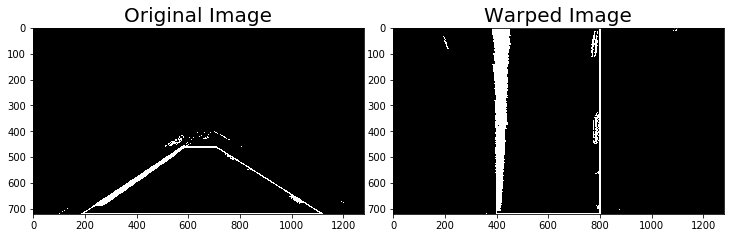

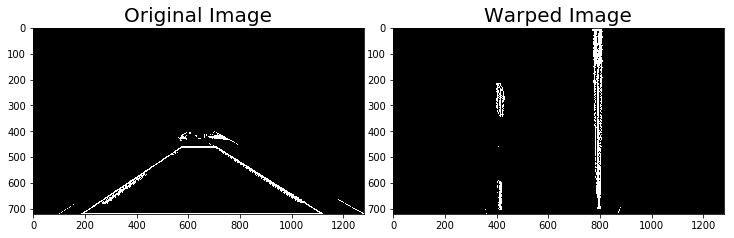

In [11]:
#define array with points of a square manually
bottom_left = [188,720]
bottom_right = [1120, 720]
top_left = [575, 460]
top_right = [708, 460]
global src
src = np.float32([top_left,bottom_left,bottom_right,top_right])
print(src)
print('----')
#define array destination points
bottom_left_dst = [400,720]
bottom_right_dst = [800, 720]
top_left_dst = [400, 1]
top_right_dst = [800, 1]
global dst
dst = np.float32([top_left_dst,bottom_left_dst,bottom_right_dst,top_right_dst])
print(dst)
# make shape of src equal to dst shape
src =src.reshape(dst.shape[0],dst.shape[1])
#call warped function
warped_img1, M_coeff = warped(binary_img1, src, dst)
#Visualize de src points over the original image
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy1 = binary_img1.copy()*255
cv2.polylines(copy1,[pts],True,(255,255,0), thickness=3)
#Visualize de dst points over the warped image 
pts_dst = np.array([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst], np.int32)
pts_dst = pts_dst.reshape((-1,1,2))
warped_img_dst1 = warped_img1.copy()*255
cv2.polylines(warped_img_dst1,[pts_dst],True,(255,255,0), thickness=3)
# visualize images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(copy1, cmap = 'gray')
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(warped_img_dst1, cmap = 'gray')
ax[1].set_title('Warped Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('camera_cal/TransformExample1Binary.jpg', transparent= False, bbox_inches='tight', pad_inches=0)
#call warped function second example image
warped_img2, M_coeff = warped(binary_img2, src, dst)
copy2 = binary_img2.copy()*255
cv2.polylines(copy2,[pts],True,(255,255,0), thickness=3)
# visualize images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(copy2, cmap = 'gray')
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(warped_img2, cmap = 'gray')
ax[1].set_title('Warped Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('output_images/TransformExample2Binary.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Identifying Lane Pixels
Type Markdown and LaTeX:  𝛼2

In this point i will create a histogram function on warped binery image in order to find the x-axis position pixels correspond to lane lines.

In [12]:
def histo(img_binary_warped):
    # Lane lines are likely to be mostly vertical nearest to the car
    img_binary_warped = img_binary_warped
    bottom_half = img_binary_warped[img_binary_warped.shape[0]//2:,:]
    # Sum across image pixels vertically, the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

* #### Testing Histogram function.

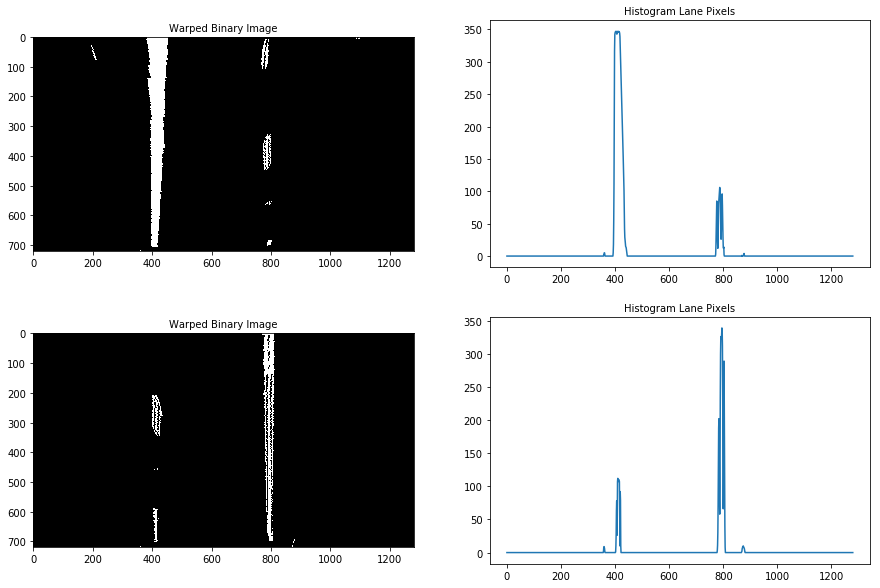

In [13]:
warped_binary1, M1_coeff = warped(binary_img1, src, dst)
warped_binary2, M1_coeff = warped(binary_img2, src, dst)
histo1 = histo(warped_binary1)
histo2 = histo(warped_binary2)
fig2, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0,0].imshow(warped_binary1, cmap = 'gray')
ax[0,0].set_title('Warped Binary Image', fontsize = 10)
ax[0,1].plot(histo1)
ax[0,1].set_title('Histogram Lane Pixels', fontsize = 10)
ax[1,0].imshow(warped_binary2, cmap = 'gray')
ax[1,0].set_title('Warped Binary Image', fontsize = 10)
ax[1,1].plot(histo2)
ax[1,1].set_title('Histogram Lane Pixels', fontsize = 10)
fig2.savefig('output_images/histogramExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)


Next, i will perform a sliding window search, starting with the base likely positions of the 2 lanes, calculated from the histogram. I have used 20 windows of height 36 pixels.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

In [14]:
def find_lane_pixels(binary_img_warped, histo, out_img):
    # Define middle point of the histrogram in order to separate the two lines
    midpoint = np.int(histo.shape[0]//2)
    print(histo.shape[0]//2)
    #Find the position of the left lane
    leftx_base = np.argmax(histo[:midpoint])
    #Find the position of the rigth lane
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_img_warped.shape[0]//nwindows)
    print()
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_img_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) & 
        (nonzerox>=win_xleft_low) & (nonzerox<=win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) & 
        (nonzerox>=win_xright_low) & (nonzerox<=win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If it found > minpix pixels, recenter next window #
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#  the coefficients are obtained from real 
def fit_polynomial(binary_img_warped, histo):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img_warped, binary_img_warped, binary_img_warped))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_img_warped, histo, out_img)
    #Fit a second order polynomial to each lane
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    print('coeff left', left_fit)
    print('coeff right', right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img_warped.shape[0]-1, binary_img_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return out_img, left_fitx, right_fitx, ploty

* #### Testing Slide Search Window

640

coeff left [-2.78141117e-05  4.70581162e-03  4.17997981e+02]
coeff right [1.39439250e-05 1.32392229e-02 7.78657352e+02]
640

coeff left [-1.40638641e-04  1.22352493e-01  3.90968895e+02]
coeff right [ 9.02861846e-06 -1.63817798e-03  7.91977840e+02]


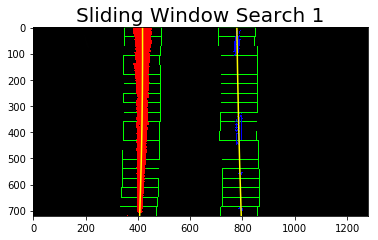

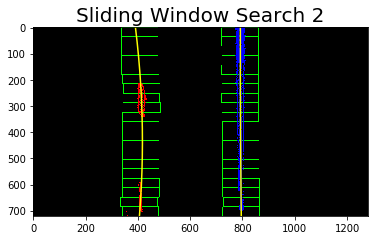

In [15]:
out_img1, left_fitx1, right_fitx1, ploty1 = fit_polynomial(warped_binary1, histo1)
out_img2, left_fitx2, right_fitx2, ploty2 = fit_polynomial(warped_binary2, histo2)

plt.figure()
plt.imshow(out_img1)
plt.title('Sliding Window Search 1', fontsize = 20)
plt.plot(left_fitx1, ploty1, color='yellow')
plt.plot(right_fitx1, ploty1, color='yellow')
plt.savefig('output_images/SlidingWindowSearch1.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(out_img2)
plt.title('Sliding Window Search 2', fontsize = 20)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')


Now, I search in a margin around the previous line position, like in the above image. The green shaded area shows where I searched for the lines this time. So, once I know where the lines are in one frame of video, I can do a highly targeted search for them in the next frame.

In [16]:
def search_around_poly(binary_warped, left_fitx, right_fitx, ploty, show = False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.polyfit(ploty,left_fitx,2)
    right_fit = np.polyfit(ploty,right_fitx,2)
    print('coeff left 2', left_fit)
    print('coeff right 2', right_fit)
    ###  Set the area of search based on activated x-values, within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox>left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] - margin) & (nonzerox<left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] + margin))
    right_lane_inds = ((nonzerox>right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] - margin) & (nonzerox<right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #--------------------
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if show:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        ## End visualization steps ##
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
    return result, left_fitx, right_fitx, ploty 



* #### Testing Search Around previous Window

coeff left 2 [-2.78141117e-05  4.70581162e-03  4.17997981e+02]
coeff right 2 [1.39439250e-05 1.32392229e-02 7.78657352e+02]
coeff left 2 [-2.78979884e-05  4.72655290e-03  4.18004621e+02]
coeff right 2 [2.98582793e-05 5.79983996e-03 7.79085234e+02]


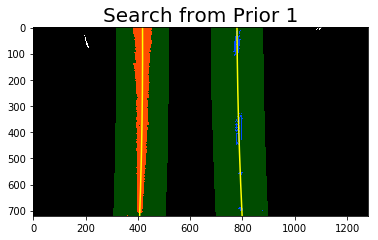

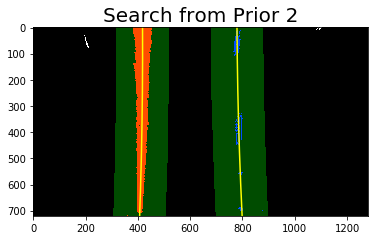

In [17]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result1, left_fitx1, right_fitx1, ploty  = search_around_poly(warped_binary1, left_fitx1, right_fitx1, ploty1, True)
result2, left_fitx2, right_fitx2, ploty  = search_around_poly(warped_binary1, left_fitx1, right_fitx1, ploty1, True)
# View the output
plt.figure()
plt.imshow(result1)
plt.title('Search from Prior 1', fontsize = 20)
plt.plot(left_fitx1, ploty, color='yellow')
plt.plot(right_fitx1, ploty, color='yellow')
plt.savefig('output_images/SearchfromPrior1.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(result2)
plt.title('Search from Prior 2', fontsize = 20)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')


## Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in [here](https://www.intmath.com/applications-differentiation/8-radius-curvature.php). Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [18]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, imgshape[1]-1, imgshape[1])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

global imgshape 
imgshape = (img.shape[1], img.shape[0])
# to the fisrt image
left_curve_rad1 = measure_radius_of_curvature(left_fitx1)
right_curve_rad1 = measure_radius_of_curvature(right_fitx1)
average_curve_rad1 = (left_curve_rad1 + right_curve_rad1)/2
# to second image
left_curve_rad2 = measure_radius_of_curvature(left_fitx2)
right_curve_rad2 = measure_radius_of_curvature(right_fitx2)
average_curve_rad2 = (left_curve_rad2 + right_curve_rad2)/2

Next. I applied the transform inverse in order to fill the space in between the identified lane lines and to highlight the driveable area in the lane. 

In [19]:
def fill_lane(Original_img, warped_binary, left_fitx, right_fitx):  
    # compute the offset from the center
    #get the center with respect to lane lines
    lane_center = (right_fitx1[-1] + left_fitx1[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #get de diference between the middle of image and lane lines center
    center_offset_pixels = abs(imgshape[0]/2 - lane_center)
    #obtain the offset center in meters
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    if center_offset_mtrs < 640:
        offset_lane = 'Vehicle is {:.2f}m left of center'.format(center_offset_mtrs)
    else:
        offset_lane = 'Vehicle is {:.2f}m right of center'.format(center_offset_mtrs)
    # Create an output image to draw on and visualize the result
    Out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    #create a vector correspond to y axis image
    y_points = np.linspace(0, imgshape[1]-1, imgshape[1])
    #generate a vector of  x-axis and y-axis lane points 
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    #stack in a consecutive vector
    point_lane = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(Out_img, np.int_([point_lane]), [0,255, 0])
    #get the matriz inverse transformation coefficient
    M_inv = cv2.getPerspectiveTransform(dst, src)
    #unwarped the image 
    unwarped = cv2.warpPerspective(Out_img, M_inv, imgshape , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(Original_img, 1, unwarped, 0.3, 0)
    return result, offset_lane


* #### Testing Fill Lane

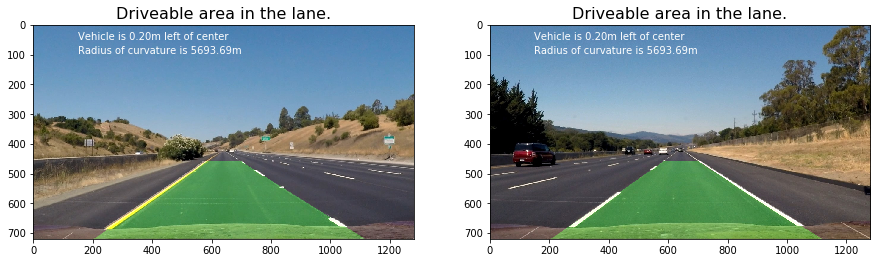

In [20]:
fill_lane1, curvature_string1 = fill_lane(img1, warped_binary1, left_fitx1, right_fitx1) 
fill_lane2, curvature_string2 = fill_lane(img2, warped_binary2, left_fitx2, right_fitx2) 
fig4, ax = plt.subplots(1,2, figsize= (15,7))
ax[0].imshow(fill_lane1)
ax[0].set_title('Driveable area in the lane.', fontsize=16)
ax[0].text(150, 50,curvature_string1 , color='white', fontsize=10)
ax[0].text(150, 95, 'Radius of curvature is {:.2f}m'.format(average_curve_rad1), color='white', fontsize=10)
ax[1].imshow(fill_lane2)
ax[1].set_title('Driveable area in the lane.', fontsize=16)
ax[1].text(150, 50,curvature_string1 , color='white', fontsize=10)
ax[1].text(150, 95, 'Radius of curvature is {:.2f}m'.format(average_curve_rad2), color='white', fontsize=10)
fig4.savefig('output_images/FillLaneExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Puting up all together
#### Figuring out bad frames

There will be some frames where no lanes will be detected or the lanes might not make sense. We determine the bad frames if any of the following conditions are met:

No pixels were detected using the sliding window search or search around the previously detected line.

The average gap between the lanes is less than 0.7 times pr greater than 1.3 times the globally maintained moving average of the lane gap.

#### Averaging lanes

The lane for each frame is a simple average of 10 previously computed lanes. This is done in the get_averaged_line method in the code block below.

if a bad frame is detected: 

* Perform a sliding window search again (this is done in the find_lane_pixels method in the code block made before)
* If this still results in a bad frame then we fall back to the previous well detected frame.



In [21]:
def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 10
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

In [22]:
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average

## Final Pipeline
We combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the pipeline_final method.

In [23]:
def pipeline_final(imgm):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    print(img_shape)
    img_size = (img_shape[1], img_shape[0])
    
    #Apply the mask
    vertices = np.array([[(100, img_size[1]),(600,400), (700, 400), (img_size[0], img_size[1])]], dtype=np.int32)
    masked = region_of_interest(img, vertices)
    # get thresholded image
    
    binary_img = gradient_thresh(masked, 7, (20, 100), (155, 255), (160, 255), show = False )
    #thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped_img, M_coeff = warped(binary_img, src, dst)
    
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    
    non_zeros = warped_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped_img.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        histogram = histo(warped_img)
        out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(warped_img, histogram)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = search_around_poly(binary_warped, left_fitx, right_fitx, ploty, show = False)
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(binary_img_warped, histo)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(binary_img_warped, histo)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    # compute the offset from the center and unwarped the image.
    result, offset_lane = fill_lane(img, warped_img, left_x_predictions, right_x_predictions)
    # Put the the info text on image
    cv2.putText(result,'Radius of curvature is {:.2f}m'.format(average_curve_rad) , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_lane, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return result

#### Testing Final Pipeline

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


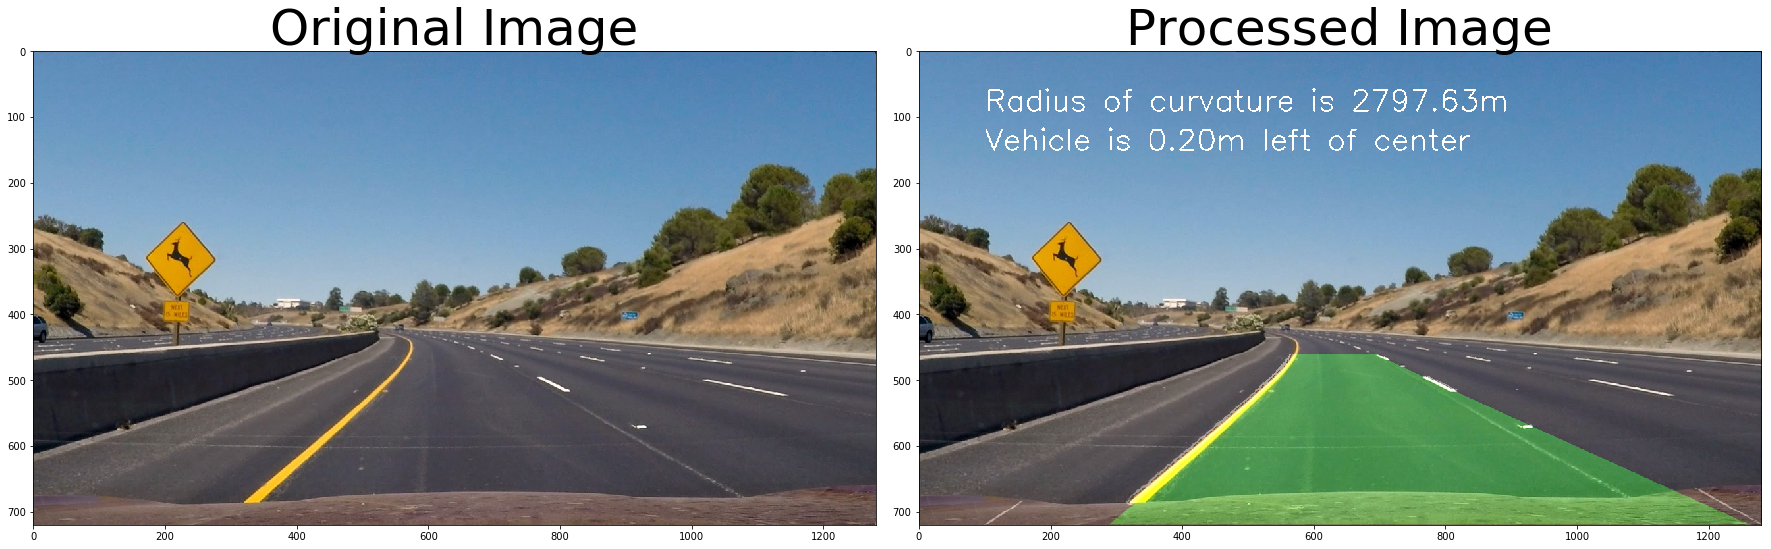

In [24]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/FinalPipeline.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

In [26]:
import moviepy.editor as mpe

In [27]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = mpe.VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4

(720, 1280, 3)


t:   0%|          | 3/1260 [00:00<01:53, 11.03it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   0%|          | 4/1260 [00:00<02:15,  9.29it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   0%|          | 6/1260 [00:00<02:33,  8.15it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|          | 7/1260 [00:00<02:51,  7.32it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   1%|          | 9/1260 [00:01<03:14,  6.45it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|          | 10/1260 [00:01<03:08,  6.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   1%|          | 11/1260 [00:01<03:32,  5.87it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|          | 12/1260 [00:01<04:03,  5.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|          | 13/1260 [00:02<04:14,  4.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   1%|          | 15/1260 [00:02<03:42,  5.59it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|▏         | 16/1260 [00:02<04:24,  4.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   1%|▏         | 17/1260 [00:02<04:33,  4.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   1%|▏         | 18/1260 [00:03<04:35,  4.51it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   2%|▏         | 19/1260 [00:03<04:45,  4.34it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   2%|▏         | 20/1260 [00:03<04:52,  4.24it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   2%|▏         | 22/1260 [00:03<04:00,  5.15it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   2%|▏         | 23/1260 [00:04<03:52,  5.32it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   2%|▏         | 24/1260 [00:04<03:51,  5.33it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   2%|▏         | 25/1260 [00:04<04:01,  5.12it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   2%|▏         | 27/1260 [00:04<03:30,  5.84it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   2%|▏         | 29/1260 [00:05<03:07,  6.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   2%|▏         | 30/1260 [00:05<03:05,  6.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   3%|▎         | 32/1260 [00:05<03:09,  6.47it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 34/1260 [00:05<02:59,  6.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 36/1260 [00:06<02:49,  7.21it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 38/1260 [00:06<02:44,  7.43it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 40/1260 [00:06<02:42,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 42/1260 [00:06<02:33,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   3%|▎         | 44/1260 [00:07<02:35,  7.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   4%|▎         | 46/1260 [00:07<02:30,  8.08it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   4%|▍         | 48/1260 [00:07<02:33,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   4%|▍         | 50/1260 [00:07<02:41,  7.48it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   4%|▍         | 51/1260 [00:08<02:46,  7.25it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   4%|▍         | 53/1260 [00:08<02:44,  7.36it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   4%|▍         | 55/1260 [00:08<02:41,  7.46it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▍         | 57/1260 [00:08<02:39,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▍         | 59/1260 [00:09<02:39,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▍         | 61/1260 [00:09<02:35,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▌         | 63/1260 [00:09<02:33,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▌         | 65/1260 [00:09<02:30,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▌         | 67/1260 [00:10<02:35,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   5%|▌         | 69/1260 [00:10<02:40,  7.41it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▌         | 71/1260 [00:10<02:35,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▌         | 73/1260 [00:10<02:33,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▌         | 75/1260 [00:11<02:31,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▌         | 77/1260 [00:11<02:37,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▋         | 79/1260 [00:11<02:33,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   6%|▋         | 81/1260 [00:11<02:33,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   7%|▋         | 83/1260 [00:12<02:29,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   7%|▋         | 84/1260 [00:12<02:30,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   7%|▋         | 86/1260 [00:12<03:03,  6.40it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   7%|▋         | 87/1260 [00:12<02:58,  6.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   7%|▋         | 88/1260 [00:13<03:21,  5.80it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   7%|▋         | 89/1260 [00:13<03:35,  5.43it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   7%|▋         | 91/1260 [00:13<03:48,  5.11it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   7%|▋         | 93/1260 [00:14<03:16,  5.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   8%|▊         | 95/1260 [00:14<02:56,  6.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   8%|▊         | 97/1260 [00:14<02:55,  6.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   8%|▊         | 98/1260 [00:14<02:51,  6.76it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   8%|▊         | 100/1260 [00:15<02:52,  6.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:   8%|▊         | 101/1260 [00:15<02:54,  6.65it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   8%|▊         | 102/1260 [00:15<02:48,  6.88it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:   8%|▊         | 104/1260 [00:15<03:00,  6.41it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   8%|▊         | 106/1260 [00:15<02:52,  6.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▊         | 108/1260 [00:16<02:42,  7.11it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▊         | 110/1260 [00:16<02:43,  7.02it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▉         | 112/1260 [00:16<02:36,  7.35it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▉         | 114/1260 [00:17<02:34,  7.42it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▉         | 116/1260 [00:17<02:32,  7.50it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:   9%|▉         | 118/1260 [00:17<02:38,  7.22it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|▉         | 120/1260 [00:17<02:35,  7.34it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|▉         | 122/1260 [00:18<02:45,  6.88it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  10%|▉         | 123/1260 [00:18<02:47,  6.78it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|▉         | 125/1260 [00:18<02:50,  6.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|█         | 127/1260 [00:18<02:43,  6.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|█         | 129/1260 [00:19<02:35,  7.25it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  10%|█         | 131/1260 [00:19<02:37,  7.18it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█         | 133/1260 [00:19<02:49,  6.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█         | 135/1260 [00:20<02:41,  6.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█         | 137/1260 [00:20<02:27,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█         | 139/1260 [00:20<02:26,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█         | 141/1260 [00:20<02:22,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  11%|█▏        | 143/1260 [00:21<02:28,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 145/1260 [00:21<02:31,  7.34it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 147/1260 [00:21<02:31,  7.33it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 149/1260 [00:21<02:28,  7.48it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 151/1260 [00:22<02:27,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 153/1260 [00:22<02:28,  7.44it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 155/1260 [00:22<02:25,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  12%|█▏        | 157/1260 [00:23<02:27,  7.45it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 159/1260 [00:23<02:24,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 161/1260 [00:23<02:33,  7.17it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 163/1260 [00:23<02:28,  7.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 165/1260 [00:24<02:26,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 167/1260 [00:24<02:21,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  13%|█▎        | 169/1260 [00:24<02:24,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▎        | 171/1260 [00:24<02:21,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▎        | 173/1260 [00:25<02:21,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▍        | 175/1260 [00:25<02:20,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▍        | 177/1260 [00:25<02:23,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▍        | 179/1260 [00:25<02:23,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  14%|█▍        | 181/1260 [00:26<02:21,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▍        | 183/1260 [00:26<02:22,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▍        | 185/1260 [00:26<02:16,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▍        | 187/1260 [00:26<02:15,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▌        | 189/1260 [00:27<02:19,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▌        | 191/1260 [00:27<02:21,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▌        | 193/1260 [00:27<02:25,  7.35it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  15%|█▌        | 195/1260 [00:28<02:25,  7.34it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▌        | 197/1260 [00:28<02:22,  7.44it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▌        | 199/1260 [00:28<02:23,  7.40it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▌        | 201/1260 [00:28<02:20,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▌        | 203/1260 [00:29<02:18,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▋        | 205/1260 [00:29<02:15,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  16%|█▋        | 207/1260 [00:29<02:15,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 209/1260 [00:29<02:12,  7.94it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 211/1260 [00:30<02:12,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 213/1260 [00:30<02:11,  7.98it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 215/1260 [00:30<02:08,  8.15it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 217/1260 [00:30<02:05,  8.34it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  17%|█▋        | 219/1260 [00:31<02:11,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 221/1260 [00:31<02:14,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 223/1260 [00:31<02:15,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 225/1260 [00:31<02:11,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 227/1260 [00:32<02:10,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 229/1260 [00:32<02:10,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 231/1260 [00:32<02:11,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  18%|█▊        | 233/1260 [00:32<02:12,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▊        | 235/1260 [00:33<02:14,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▉        | 237/1260 [00:33<02:16,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▉        | 239/1260 [00:33<02:16,  7.47it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▉        | 241/1260 [00:34<02:25,  7.02it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▉        | 243/1260 [00:34<02:18,  7.32it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  19%|█▉        | 245/1260 [00:34<02:16,  7.44it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|█▉        | 247/1260 [00:34<02:11,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|█▉        | 249/1260 [00:35<02:12,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|█▉        | 251/1260 [00:35<02:11,  7.69it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|██        | 253/1260 [00:35<02:10,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|██        | 255/1260 [00:35<02:07,  7.89it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  20%|██        | 257/1260 [00:36<02:11,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██        | 259/1260 [00:36<02:12,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██        | 261/1260 [00:36<02:10,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██        | 263/1260 [00:36<02:06,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██        | 265/1260 [00:37<02:08,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██        | 267/1260 [00:37<02:06,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  21%|██▏       | 269/1260 [00:37<02:06,  7.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 271/1260 [00:37<02:06,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 273/1260 [00:38<02:08,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 275/1260 [00:38<02:09,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 277/1260 [00:38<02:08,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 279/1260 [00:38<02:08,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 281/1260 [00:39<02:07,  7.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  22%|██▏       | 283/1260 [00:39<02:12,  7.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 285/1260 [00:39<02:08,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 287/1260 [00:40<02:07,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 289/1260 [00:40<02:09,  7.51it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 291/1260 [00:40<02:07,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 293/1260 [00:40<02:05,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  23%|██▎       | 295/1260 [00:41<02:03,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▎       | 297/1260 [00:41<01:59,  8.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▎       | 299/1260 [00:41<02:06,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▍       | 301/1260 [00:41<02:05,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▍       | 303/1260 [00:42<02:06,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▍       | 305/1260 [00:42<02:01,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  24%|██▍       | 307/1260 [00:42<02:02,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▍       | 309/1260 [00:42<01:59,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▍       | 311/1260 [00:43<01:59,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▍       | 313/1260 [00:43<01:59,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▌       | 315/1260 [00:43<02:03,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▌       | 317/1260 [00:43<02:05,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▌       | 319/1260 [00:44<02:11,  7.18it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  25%|██▌       | 321/1260 [00:44<02:08,  7.30it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▌       | 323/1260 [00:44<02:04,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▌       | 325/1260 [00:45<02:04,  7.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▌       | 327/1260 [00:45<01:59,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▌       | 329/1260 [00:45<01:58,  7.88it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▋       | 331/1260 [00:45<01:55,  8.06it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  26%|██▋       | 333/1260 [00:46<01:58,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 335/1260 [00:46<01:58,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 337/1260 [00:46<02:02,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 339/1260 [00:46<02:00,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 341/1260 [00:47<02:00,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 343/1260 [00:47<02:00,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  27%|██▋       | 345/1260 [00:47<02:00,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 347/1260 [00:47<01:59,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 349/1260 [00:48<01:58,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 351/1260 [00:48<01:55,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 353/1260 [00:48<01:56,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 355/1260 [00:48<01:54,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 357/1260 [00:49<01:56,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  28%|██▊       | 359/1260 [00:49<01:53,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▊       | 361/1260 [00:49<01:52,  7.98it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▉       | 363/1260 [00:49<01:57,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▉       | 365/1260 [00:50<01:57,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▉       | 367/1260 [00:50<01:59,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▉       | 369/1260 [00:50<01:56,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  29%|██▉       | 371/1260 [00:51<01:55,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|██▉       | 373/1260 [00:51<01:53,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|██▉       | 375/1260 [00:51<01:52,  7.89it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|██▉       | 377/1260 [00:51<01:50,  8.01it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|███       | 379/1260 [00:52<01:50,  7.99it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|███       | 381/1260 [00:52<01:50,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  30%|███       | 383/1260 [00:52<01:54,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███       | 385/1260 [00:52<01:53,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███       | 387/1260 [00:53<01:51,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███       | 389/1260 [00:53<01:48,  8.05it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███       | 391/1260 [00:53<01:46,  8.15it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███       | 393/1260 [00:53<01:46,  8.13it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  31%|███▏      | 395/1260 [00:54<01:48,  8.00it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 397/1260 [00:54<01:49,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 399/1260 [00:54<01:58,  7.27it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 401/1260 [00:54<02:06,  6.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  32%|███▏      | 402/1260 [00:55<02:12,  6.50it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 404/1260 [00:55<02:06,  6.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 405/1260 [00:55<02:05,  6.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  32%|███▏      | 407/1260 [00:55<02:12,  6.44it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  32%|███▏      | 409/1260 [00:56<02:00,  7.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 411/1260 [00:56<01:57,  7.24it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 413/1260 [00:56<01:57,  7.22it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 415/1260 [00:56<01:58,  7.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 416/1260 [00:57<02:06,  6.69it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:  33%|███▎      | 418/1260 [00:57<02:05,  6.72it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 420/1260 [00:57<01:56,  7.19it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  33%|███▎      | 422/1260 [00:57<01:49,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▎      | 423/1260 [00:58<01:57,  7.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  34%|███▎      | 425/1260 [00:58<02:11,  6.33it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 427/1260 [00:58<01:59,  6.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 429/1260 [00:58<01:51,  7.43it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 431/1260 [00:59<01:54,  7.25it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 432/1260 [00:59<01:57,  7.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 433/1260 [00:59<02:50,  4.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  34%|███▍      | 434/1260 [00:59<02:50,  4.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  35%|███▍      | 435/1260 [01:00<02:55,  4.69it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  35%|███▍      | 437/1260 [01:00<02:36,  5.25it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  35%|███▍      | 439/1260 [01:00<02:17,  5.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:  35%|███▌      | 441/1260 [01:01<02:29,  5.47it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  35%|███▌      | 443/1260 [01:01<02:14,  6.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  35%|███▌      | 444/1260 [01:01<02:22,  5.71it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  35%|███▌      | 446/1260 [01:02<02:15,  6.01it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  36%|███▌      | 448/1260 [01:02<02:07,  6.39it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  36%|███▌      | 450/1260 [01:02<02:04,  6.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  36%|███▌      | 451/1260 [01:02<02:03,  6.55it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  36%|███▌      | 453/1260 [01:03<02:02,  6.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  36%|███▌      | 454/1260 [01:03<02:02,  6.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  36%|███▌      | 456/1260 [01:03<02:02,  6.56it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  36%|███▋      | 458/1260 [01:03<01:52,  7.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  37%|███▋      | 460/1260 [01:04<01:51,  7.19it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  37%|███▋      | 461/1260 [01:04<02:13,  6.00it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  37%|███▋      | 462/1260 [01:04<02:19,  5.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  37%|███▋      | 464/1260 [01:04<02:24,  5.52it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  37%|███▋      | 466/1260 [01:05<02:23,  5.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  37%|███▋      | 468/1260 [01:05<02:10,  6.06it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  37%|███▋      | 470/1260 [01:05<02:00,  6.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  37%|███▋      | 471/1260 [01:06<02:06,  6.23it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 473/1260 [01:06<02:00,  6.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 474/1260 [01:06<01:59,  6.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  38%|███▊      | 476/1260 [01:06<01:59,  6.56it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 478/1260 [01:07<01:50,  7.09it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 480/1260 [01:07<01:45,  7.37it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 482/1260 [01:07<01:41,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  38%|███▊      | 484/1260 [01:07<01:40,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▊      | 486/1260 [01:08<01:41,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▊      | 488/1260 [01:08<01:39,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▉      | 490/1260 [01:08<01:38,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▉      | 492/1260 [01:08<01:36,  7.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▉      | 494/1260 [01:09<01:35,  8.05it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  39%|███▉      | 496/1260 [01:09<01:37,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|███▉      | 498/1260 [01:09<01:39,  7.69it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|███▉      | 500/1260 [01:09<01:37,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|███▉      | 502/1260 [01:10<01:36,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|████      | 504/1260 [01:10<01:34,  7.97it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|████      | 506/1260 [01:10<01:36,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|████      | 508/1260 [01:10<01:35,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  40%|████      | 510/1260 [01:11<01:35,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████      | 512/1260 [01:11<01:34,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████      | 514/1260 [01:11<01:32,  8.10it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████      | 516/1260 [01:11<01:30,  8.18it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████      | 518/1260 [01:12<01:30,  8.17it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████▏     | 520/1260 [01:12<01:28,  8.35it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  41%|████▏     | 522/1260 [01:12<01:28,  8.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 524/1260 [01:12<01:30,  8.13it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 526/1260 [01:13<01:35,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 528/1260 [01:13<01:36,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 530/1260 [01:13<01:34,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 532/1260 [01:13<01:34,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  42%|████▏     | 534/1260 [01:14<01:38,  7.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 536/1260 [01:14<01:37,  7.42it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 538/1260 [01:14<01:37,  7.41it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 540/1260 [01:15<01:36,  7.47it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 542/1260 [01:15<01:39,  7.23it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  43%|████▎     | 543/1260 [01:15<01:44,  6.84it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 545/1260 [01:15<01:40,  7.10it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  43%|████▎     | 547/1260 [01:15<01:35,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▎     | 549/1260 [01:16<01:39,  7.15it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▎     | 551/1260 [01:16<01:36,  7.36it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▍     | 553/1260 [01:16<01:33,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▍     | 555/1260 [01:17<01:32,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▍     | 557/1260 [01:17<01:32,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  44%|████▍     | 559/1260 [01:17<01:31,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▍     | 561/1260 [01:17<01:30,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▍     | 563/1260 [01:18<01:32,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▍     | 565/1260 [01:18<01:30,  7.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▌     | 567/1260 [01:18<01:33,  7.45it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▌     | 569/1260 [01:18<01:28,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▌     | 571/1260 [01:19<01:27,  7.89it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  45%|████▌     | 573/1260 [01:19<01:25,  7.99it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▌     | 575/1260 [01:19<01:26,  7.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▌     | 577/1260 [01:19<01:30,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▌     | 579/1260 [01:20<01:30,  7.48it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▌     | 581/1260 [01:20<01:29,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▋     | 583/1260 [01:20<01:29,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  46%|████▋     | 585/1260 [01:21<01:28,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 587/1260 [01:21<01:29,  7.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 589/1260 [01:21<01:29,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 591/1260 [01:21<01:27,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 593/1260 [01:22<01:28,  7.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 595/1260 [01:22<01:26,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  47%|████▋     | 597/1260 [01:22<01:27,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 599/1260 [01:22<01:25,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 601/1260 [01:23<01:28,  7.42it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 603/1260 [01:23<01:26,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 605/1260 [01:23<01:25,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 607/1260 [01:23<01:23,  7.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 609/1260 [01:24<01:24,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  48%|████▊     | 611/1260 [01:24<01:23,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  49%|████▊     | 613/1260 [01:24<01:25,  7.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  49%|████▉     | 615/1260 [01:24<01:24,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  49%|████▉     | 617/1260 [01:25<01:26,  7.41it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  49%|████▉     | 619/1260 [01:25<01:27,  7.31it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  49%|████▉     | 620/1260 [01:25<01:33,  6.85it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  49%|████▉     | 622/1260 [01:25<01:24,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|████▉     | 624/1260 [01:26<01:22,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|████▉     | 626/1260 [01:26<01:22,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|████▉     | 628/1260 [01:26<01:23,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|█████     | 630/1260 [01:26<01:22,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|█████     | 632/1260 [01:27<01:23,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|█████     | 634/1260 [01:27<01:22,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  50%|█████     | 636/1260 [01:27<01:21,  7.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████     | 638/1260 [01:28<01:23,  7.46it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████     | 640/1260 [01:28<01:22,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████     | 642/1260 [01:28<01:21,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████     | 644/1260 [01:28<01:17,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████▏    | 646/1260 [01:29<01:18,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  51%|█████▏    | 648/1260 [01:29<01:16,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 650/1260 [01:29<01:18,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 652/1260 [01:29<01:18,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 654/1260 [01:30<01:19,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 656/1260 [01:30<01:18,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 658/1260 [01:30<01:19,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  52%|█████▏    | 660/1260 [01:30<01:17,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 662/1260 [01:31<01:19,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 664/1260 [01:31<01:16,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 666/1260 [01:31<01:17,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 668/1260 [01:31<01:15,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 670/1260 [01:32<01:17,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 672/1260 [01:32<01:17,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  53%|█████▎    | 674/1260 [01:32<01:16,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▎    | 676/1260 [01:32<01:15,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▍    | 678/1260 [01:33<01:15,  7.72it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▍    | 680/1260 [01:33<01:14,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▍    | 682/1260 [01:33<01:15,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▍    | 684/1260 [01:34<01:15,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  54%|█████▍    | 686/1260 [01:34<01:13,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▍    | 688/1260 [01:34<01:12,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▍    | 690/1260 [01:34<01:11,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▍    | 692/1260 [01:35<01:12,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▌    | 694/1260 [01:35<01:11,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▌    | 696/1260 [01:35<01:12,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  55%|█████▌    | 698/1260 [01:35<01:16,  7.39it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▌    | 700/1260 [01:36<01:16,  7.28it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▌    | 702/1260 [01:36<01:12,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▌    | 704/1260 [01:36<01:14,  7.45it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▌    | 706/1260 [01:36<01:12,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▌    | 708/1260 [01:37<01:12,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  56%|█████▋    | 710/1260 [01:37<01:12,  7.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 712/1260 [01:37<01:12,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 714/1260 [01:37<01:11,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 716/1260 [01:38<01:11,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 718/1260 [01:38<01:11,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 720/1260 [01:38<01:11,  7.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 722/1260 [01:39<01:13,  7.27it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  57%|█████▋    | 724/1260 [01:39<01:10,  7.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 726/1260 [01:39<01:09,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 728/1260 [01:39<01:07,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 730/1260 [01:40<01:08,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 732/1260 [01:40<01:07,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 734/1260 [01:40<01:09,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  58%|█████▊    | 736/1260 [01:40<01:07,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▊    | 738/1260 [01:41<01:10,  7.43it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▊    | 740/1260 [01:41<01:08,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▉    | 742/1260 [01:41<01:08,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▉    | 744/1260 [01:41<01:06,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▉    | 746/1260 [01:42<01:07,  7.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  59%|█████▉    | 748/1260 [01:42<01:06,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|█████▉    | 750/1260 [01:42<01:06,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|█████▉    | 752/1260 [01:42<01:05,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|█████▉    | 754/1260 [01:43<01:06,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|██████    | 756/1260 [01:43<01:05,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|██████    | 758/1260 [01:43<01:05,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|██████    | 760/1260 [01:44<01:05,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  60%|██████    | 762/1260 [01:44<01:05,  7.65it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████    | 764/1260 [01:44<01:04,  7.72it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████    | 766/1260 [01:44<01:03,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████    | 768/1260 [01:45<01:03,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████    | 770/1260 [01:45<01:03,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████▏   | 772/1260 [01:45<01:02,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  61%|██████▏   | 774/1260 [01:45<01:01,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 776/1260 [01:46<01:01,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 778/1260 [01:46<01:05,  7.33it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 780/1260 [01:46<01:03,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 782/1260 [01:46<01:00,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 784/1260 [01:47<01:02,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  62%|██████▏   | 786/1260 [01:47<01:02,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 788/1260 [01:47<01:01,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 790/1260 [01:47<00:59,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 792/1260 [01:48<00:59,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 794/1260 [01:48<01:00,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 796/1260 [01:48<01:01,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  63%|██████▎   | 798/1260 [01:49<01:01,  7.45it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)

t:  63%|██████▎   | 799/1260 [01:49<01:04,  7.17it/s, now=None]


640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▎   | 801/1260 [01:49<01:01,  7.47it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▎   | 803/1260 [01:49<01:02,  7.35it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▍   | 805/1260 [01:49<01:02,  7.26it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▍   | 807/1260 [01:50<01:01,  7.33it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▍   | 809/1260 [01:50<00:59,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  64%|██████▍   | 811/1260 [01:50<01:00,  7.40it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▍   | 813/1260 [01:51<00:59,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▍   | 815/1260 [01:51<00:57,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▍   | 817/1260 [01:51<00:57,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▌   | 819/1260 [01:51<00:56,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▌   | 821/1260 [01:52<00:56,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▌   | 823/1260 [01:52<00:54,  8.00it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  65%|██████▌   | 825/1260 [01:52<00:55,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▌   | 827/1260 [01:52<00:55,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▌   | 829/1260 [01:53<00:54,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▌   | 831/1260 [01:53<00:53,  8.01it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▌   | 833/1260 [01:53<00:54,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▋   | 835/1260 [01:53<00:52,  8.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  66%|██████▋   | 837/1260 [01:54<00:53,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 839/1260 [01:54<00:54,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 841/1260 [01:54<00:55,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 843/1260 [01:54<00:54,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 845/1260 [01:55<00:55,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 847/1260 [01:55<00:54,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  67%|██████▋   | 849/1260 [01:55<00:53,  7.69it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 851/1260 [01:55<00:52,  7.72it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 853/1260 [01:56<00:52,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 855/1260 [01:56<00:54,  7.45it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 857/1260 [01:56<00:55,  7.24it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 859/1260 [01:57<00:53,  7.51it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 861/1260 [01:57<00:52,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  68%|██████▊   | 863/1260 [01:57<00:51,  7.72it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▊   | 865/1260 [01:57<00:51,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▉   | 867/1260 [01:58<00:52,  7.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▉   | 869/1260 [01:58<00:51,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▉   | 871/1260 [01:58<00:51,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▉   | 873/1260 [01:58<00:50,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  69%|██████▉   | 875/1260 [01:59<00:50,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|██████▉   | 877/1260 [01:59<00:49,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|██████▉   | 879/1260 [01:59<00:48,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|██████▉   | 881/1260 [01:59<00:48,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|███████   | 883/1260 [02:00<00:49,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|███████   | 885/1260 [02:00<00:49,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  70%|███████   | 887/1260 [02:00<00:48,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████   | 889/1260 [02:00<00:48,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████   | 891/1260 [02:01<00:48,  7.55it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████   | 893/1260 [02:01<00:48,  7.64it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████   | 895/1260 [02:01<00:49,  7.44it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████   | 897/1260 [02:02<00:48,  7.48it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  71%|███████▏  | 899/1260 [02:02<00:48,  7.46it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 901/1260 [02:02<00:47,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 903/1260 [02:02<00:46,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 905/1260 [02:03<00:46,  7.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 907/1260 [02:03<00:46,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 909/1260 [02:03<00:46,  7.54it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 911/1260 [02:03<00:45,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  72%|███████▏  | 913/1260 [02:04<00:47,  7.27it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 915/1260 [02:04<00:46,  7.43it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 917/1260 [02:04<00:45,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 919/1260 [02:04<00:43,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 921/1260 [02:05<00:43,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 923/1260 [02:05<00:41,  8.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  73%|███████▎  | 925/1260 [02:05<00:41,  8.00it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▎  | 927/1260 [02:05<00:41,  8.05it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▎  | 929/1260 [02:06<00:41,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▍  | 931/1260 [02:06<00:41,  7.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▍  | 933/1260 [02:06<00:42,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▍  | 935/1260 [02:07<00:45,  7.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  74%|███████▍  | 936/1260 [02:07<00:46,  6.93it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  74%|███████▍  | 938/1260 [02:07<00:42,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▍  | 940/1260 [02:07<00:40,  7.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▍  | 942/1260 [02:07<00:40,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▍  | 944/1260 [02:08<00:40,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▌  | 946/1260 [02:08<00:40,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▌  | 948/1260 [02:08<00:40,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  75%|███████▌  | 950/1260 [02:08<00:40,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▌  | 952/1260 [02:09<00:41,  7.51it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▌  | 954/1260 [02:09<00:39,  7.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▌  | 956/1260 [02:09<00:38,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▌  | 958/1260 [02:10<00:38,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▌  | 960/1260 [02:10<00:39,  7.67it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  76%|███████▋  | 962/1260 [02:10<00:38,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 964/1260 [02:10<00:38,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 966/1260 [02:11<00:38,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 968/1260 [02:11<00:37,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 970/1260 [02:11<00:37,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 972/1260 [02:11<00:36,  7.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 974/1260 [02:12<00:36,  7.74it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  77%|███████▋  | 976/1260 [02:12<00:36,  7.68it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  78%|███████▊  | 977/1260 [02:12<00:41,  6.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:  78%|███████▊  | 979/1260 [02:12<00:38,  7.28it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  78%|███████▊  | 980/1260 [02:12<00:38,  7.23it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  78%|███████▊  | 982/1260 [02:13<00:40,  6.85it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  78%|███████▊  | 983/1260 [02:13<00:40,  6.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]

t:  78%|███████▊  | 985/1260 [02:13<00:42,  6.43it/s, now=None]


coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  78%|███████▊  | 987/1260 [02:14<00:39,  6.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  78%|███████▊  | 988/1260 [02:14<00:38,  7.03it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▊  | 990/1260 [02:14<00:41,  6.46it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▊  | 992/1260 [02:14<00:38,  6.89it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▉  | 994/1260 [02:15<00:38,  6.95it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▉  | 996/1260 [02:15<00:38,  6.90it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▉  | 998/1260 [02:15<00:36,  7.23it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  79%|███████▉  | 1000/1260 [02:15<00:34,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|███████▉  | 1002/1260 [02:16<00:34,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|███████▉  | 1004/1260 [02:16<00:36,  7.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|███████▉  | 1006/1260 [02:16<00:35,  7.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|████████  | 1008/1260 [02:17<00:34,  7.27it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|████████  | 1010/1260 [02:17<00:35,  6.97it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|████████  | 1012/1260 [02:17<00:34,  7.16it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  80%|████████  | 1014/1260 [02:17<00:32,  7.47it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████  | 1016/1260 [02:18<00:34,  7.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████  | 1017/1260 [02:18<00:37,  6.50it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████  | 1019/1260 [02:18<00:36,  6.58it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████  | 1021/1260 [02:18<00:33,  7.16it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████  | 1023/1260 [02:19<00:32,  7.26it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  81%|████████▏ | 1025/1260 [02:19<00:31,  7.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1027/1260 [02:19<00:31,  7.40it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1029/1260 [02:20<00:33,  6.84it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1031/1260 [02:20<00:32,  7.09it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1033/1260 [02:20<00:30,  7.36it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1035/1260 [02:20<00:32,  6.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  82%|████████▏ | 1036/1260 [02:20<00:31,  7.09it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  82%|████████▏ | 1038/1260 [02:21<00:30,  7.28it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1040/1260 [02:21<00:30,  7.22it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1042/1260 [02:21<00:28,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1044/1260 [02:22<00:29,  7.32it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1046/1260 [02:22<00:28,  7.38it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1048/1260 [02:22<00:28,  7.32it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1050/1260 [02:22<00:28,  7.49it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  83%|████████▎ | 1052/1260 [02:23<00:27,  7.59it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▎ | 1054/1260 [02:23<00:26,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▍ | 1056/1260 [02:23<00:25,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▍ | 1058/1260 [02:23<00:25,  7.94it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▍ | 1060/1260 [02:24<00:25,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▍ | 1062/1260 [02:24<00:25,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  84%|████████▍ | 1064/1260 [02:24<00:24,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▍ | 1066/1260 [02:24<00:23,  8.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▍ | 1068/1260 [02:25<00:23,  8.06it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▍ | 1070/1260 [02:25<00:23,  8.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▌ | 1072/1260 [02:25<00:23,  8.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▌ | 1074/1260 [02:25<00:22,  8.21it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  85%|████████▌ | 1076/1260 [02:26<00:22,  8.12it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1078/1260 [02:26<00:22,  8.04it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1080/1260 [02:26<00:22,  8.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1082/1260 [02:26<00:21,  8.18it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1084/1260 [02:27<00:21,  8.10it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1085/1260 [02:27<00:22,  7.66it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  86%|████████▌ | 1086/1260 [02:27<00:26,  6.52it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  86%|████████▋ | 1088/1260 [02:27<00:24,  7.01it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1090/1260 [02:28<00:22,  7.46it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1092/1260 [02:28<00:22,  7.62it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1094/1260 [02:28<00:21,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1096/1260 [02:28<00:20,  8.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1098/1260 [02:29<00:20,  8.05it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1100/1260 [02:29<00:19,  8.02it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  87%|████████▋ | 1102/1260 [02:29<00:19,  8.00it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1104/1260 [02:29<00:19,  8.01it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1106/1260 [02:30<00:19,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1108/1260 [02:30<00:19,  7.81it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1110/1260 [02:30<00:19,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1112/1260 [02:30<00:18,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  88%|████████▊ | 1114/1260 [02:31<00:18,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▊ | 1116/1260 [02:31<00:18,  7.63it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▊ | 1118/1260 [02:31<00:18,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▉ | 1120/1260 [02:31<00:17,  7.78it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▉ | 1122/1260 [02:32<00:17,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▉ | 1124/1260 [02:32<00:17,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  89%|████████▉ | 1126/1260 [02:32<00:17,  7.57it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|████████▉ | 1128/1260 [02:32<00:16,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|████████▉ | 1130/1260 [02:33<00:16,  7.79it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|████████▉ | 1132/1260 [02:33<00:16,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|█████████ | 1134/1260 [02:33<00:16,  7.72it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|█████████ | 1136/1260 [02:33<00:15,  7.86it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|█████████ | 1138/1260 [02:34<00:15,  7.73it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  90%|█████████ | 1140/1260 [02:34<00:15,  7.97it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  91%|█████████ | 1142/1260 [02:34<00:14,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  91%|█████████ | 1144/1260 [02:34<00:14,  8.17it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  91%|█████████ | 1146/1260 [02:35<00:14,  7.94it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  91%|█████████ | 1148/1260 [02:35<00:13,  8.11it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  91%|█████████ | 1149/1260 [02:35<00:13,  7.94it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640



t:  91%|█████████▏| 1151/1260 [02:35<00:14,  7.34it/s, now=None]

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1153/1260 [02:36<00:14,  7.53it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1155/1260 [02:36<00:14,  7.17it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1157/1260 [02:36<00:13,  7.37it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1159/1260 [02:36<00:13,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]


t:  92%|█████████▏| 1160/1260 [02:37<00:14,  6.86it/s, now=None]

(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1162/1260 [02:37<00:13,  7.20it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  92%|█████████▏| 1164/1260 [02:37<00:13,  7.34it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1166/1260 [02:37<00:12,  7.24it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1168/1260 [02:38<00:12,  7.40it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1170/1260 [02:38<00:11,  7.56it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1172/1260 [02:38<00:11,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1174/1260 [02:38<00:10,  7.87it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1176/1260 [02:39<00:10,  8.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  93%|█████████▎| 1178/1260 [02:39<00:10,  8.17it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▎| 1180/1260 [02:39<00:10,  7.99it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▍| 1182/1260 [02:39<00:09,  8.00it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▍| 1184/1260 [02:40<00:09,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▍| 1186/1260 [02:40<00:09,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▍| 1188/1260 [02:40<00:09,  7.71it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  94%|█████████▍| 1190/1260 [02:40<00:08,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▍| 1192/1260 [02:41<00:08,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▍| 1194/1260 [02:41<00:08,  7.97it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▍| 1196/1260 [02:41<00:08,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▌| 1198/1260 [02:42<00:07,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▌| 1200/1260 [02:42<00:07,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  95%|█████████▌| 1202/1260 [02:42<00:07,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▌| 1204/1260 [02:42<00:07,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▌| 1206/1260 [02:43<00:06,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▌| 1208/1260 [02:43<00:06,  7.93it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▌| 1210/1260 [02:43<00:06,  7.92it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▌| 1212/1260 [02:43<00:06,  7.94it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  96%|█████████▋| 1214/1260 [02:44<00:05,  7.85it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1216/1260 [02:44<00:05,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1218/1260 [02:44<00:05,  7.76it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1220/1260 [02:44<00:05,  7.70it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1222/1260 [02:45<00:04,  7.89it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1224/1260 [02:45<00:04,  7.91it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1226/1260 [02:45<00:04,  8.06it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  97%|█████████▋| 1228/1260 [02:45<00:03,  8.07it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1230/1260 [02:46<00:03,  8.08it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1232/1260 [02:46<00:03,  8.05it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1234/1260 [02:46<00:03,  8.14it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1236/1260 [02:46<00:02,  8.10it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1238/1260 [02:47<00:02,  8.13it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  98%|█████████▊| 1240/1260 [02:47<00:02,  7.88it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▊| 1242/1260 [02:47<00:02,  7.80it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▊| 1244/1260 [02:47<00:02,  7.75it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▉| 1246/1260 [02:48<00:01,  7.29it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▉| 1248/1260 [02:48<00:01,  7.61it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▉| 1250/1260 [02:48<00:01,  7.60it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t:  99%|█████████▉| 1252/1260 [02:48<00:01,  7.83it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t: 100%|█████████▉| 1254/1260 [02:49<00:00,  7.77it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t: 100%|█████████▉| 1256/1260 [02:49<00:00,  7.96it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t: 100%|█████████▉| 1258/1260 [02:49<00:00,  8.02it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


t: 100%|██████████| 1260/1260 [02:49<00:00,  7.82it/s, now=None]

640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)
640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
(720, 1280, 3)


640

coeff left [-1.32840679e-04  1.72668488e-01  3.88348933e+02]
coeff right [3.77029806e-05 1.19438720e-01 7.55967417e+02]
Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 2min 46s, sys: 23.5 s, total: 3min 10s
Wall time: 2min 50s


In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'challenge_video_output1.mp4'
clip1 = mpe.VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

#### Generate Gif to Readme

In [20]:
def convertFile(inputpath, targetFormat):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    outputpath = os.path.splitext(inputpath)[0] + targetFormat
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))
    #read the input video
    reader = imageio.get_reader(inputpath)
    #get the frame per second of the video
    fps = reader.get_meta_data()['fps']
    print(fps/29.97)
    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        if i == 50:
            break
        else:
            sys.stdout.write("\rframe {0}".format(i))
            sys.stdout.flush()
            writer.append_data(im)
    print("\r\nFinalizing...")
    #writer.close()
    print("Done.")

In [21]:
convertFile('challenge_video_output1.mp4', '.gif')

converting
	challenge_video_output1.mp4
to
	challenge_video_output1.gif
1.0
frame 49
Finalizing...
Done.
